In this notebook we analyse the power in predicting IMT from the activation maps during the FACES task. In order to address this, we adopted a machine learning approach. Our data consist of ~ 450 subjects from AHAB study (i.e. obvervations) and about 200.000 voxels (i.e. features). 

We've got two problems here. First, the number of features exceeds the number of observations, so we are at risk of overfitting. Second, voxels are usually correlated to each other, providing then redundant information when combined. In order to deal with these two problems, we built a Lasso-PCR estimator, such that it first applies a PCA to reduce the dimensionality of the data to the Principal Components space and then shrinks those components that are less important with respect to IMT. 

By means of a nested cross-validation, we assessed the generalisation of the model (outer loop) and the optimal value of the regularisation coefficient (inner loop). The folds in the outer loop have been generated in a stratified fashion way such that there are not differences between the training and test set in IMT as measured by a Kolmogorv-Smirnov test.

In [168]:
# Here the imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os.path import join as opj
import seaborn as sns
import os
import time
from joblib import Parallel, delayed

from nilearn import masking, image, plotting
from sklearn.model_selection import (StratifiedKFold, cross_validate, cross_val_predict)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LassoCV
from scipy.stats import ks_2samp, pearsonr
from sklearn.utils import resample
from glob import glob

In [8]:
# The working directory
work_dir = os.path.abspath("../")

In [6]:
# For reproducibility
RANDOM_STATE = 0

In [9]:
# Mask with the greatest voxel coverage 
mask_img = image.load_img(img=opj(work_dir,"data", "reslicedER_grey25grey25.nii"))

In [23]:
# The subjects from in the whole project folder
subjs_dats = glob(opj(work_dir, "data", "faces","*"))
subject_list = [path.split("/")[-1] for path in subjs_dats]

In [25]:
all_data = pd.read_csv(opj(work_dir,  "data", "all_data.csv"))

In [32]:
# Here we select the subjects for each task

old_faces_subs = all_data[~all_data.ID_OF.isna()].ID_OF.astype(int).to_list()
print("The number of subjects performing OLD faces task is ", len(old_faces_subs))

new_faces_subs = all_data[~all_data.ID_NF.isna()].ID_NF.astype(int).to_list()
print("The number of subjects performing NEW faces task is ", len(new_faces_subs))


The number of subjects performing OLD faces task is  427
The number of subjects performing NEW faces task is  451


In [33]:
# Here the IMT values for each task
y_old_faces =  all_data[~all_data.ID_OF.isna()].imt.values
y_new_faces =  all_data[~all_data.ID_NF.isna()].imt.values

# OLD FACES TASK

- ommnibus_case = AllFaces > Shapes

In [77]:
omnibus_case = "OldFaces/con_0001.nii"

In [80]:
X = masking.apply_mask(imgs=[opj(work_dir, "data", "faces", str(sub), omnibus_case) \
          for sub in old_faces_subs], mask_img = mask_img)

In [81]:
discrete_old_faces = np.digitize(y_old_faces, np.quantile(y_old_faces, q=[0.2, 0.4, 0.6, 0.8]))

We can see that the training and test are not significantly different in terms of IMT, as measured by means of a Kolmogorov-Smirnov test

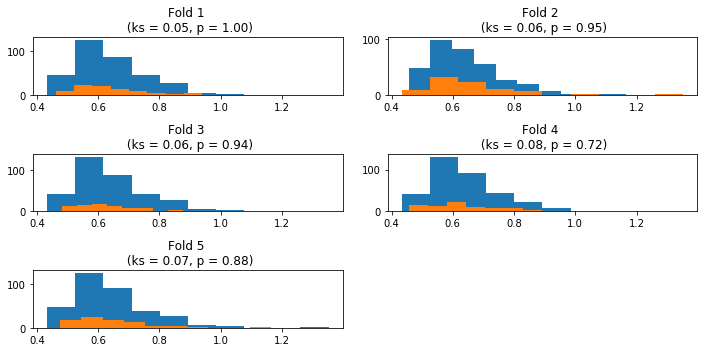

In [82]:
from scipy.stats import ks_2samp

cv = StratifiedKFold(n_splits=5,  shuffle = True, random_state=RANDOM_STATE).split(np.zeros(len(discrete_old_faces)), 
                                                                                   discrete_old_faces)

fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(10,5))
axs = axs.flatten()

for ii, (train_index, test_index) in enumerate(cv):
    
    y_train, y_test = y_old_faces[train_index], y_old_faces[test_index]
    
    axs[ii].hist(y_train, label="training")
    axs[ii].hist(y_test, label="test")
    
    ks, p = ks_2samp(y_train, y_test)
    axs[ii].set_title("Fold {:d} \n (ks = {:.2f}, p = {:.2f})".format(ii + 1, ks, p))
    
fig.delaxes(axs[-1])
plt.tight_layout()

In [86]:
clf = make_pipeline(StandardScaler(with_std=False),
                    PCA(n_components = 0.95), LassoCV(max_iter=1e5,random_state=RANDOM_STATE, cv=5))

cv = StratifiedKFold(n_splits=5,  shuffle = True, random_state=RANDOM_STATE).split(np.zeros(len(discrete_old_faces)), 
                                                                                   discrete_old_faces)

y_pred = cross_val_predict(clf, X, y_old_faces, cv=cv, n_jobs=-1)

In [109]:
r, p = pearsonr(y_old_faces, y_pred)

In [112]:
n_boot = 10000

corr_boot = []
np.random.seed(RANDOM_STATE)
for ii in range(n_boot):
    boot_idxs = np.random.choice(a = len(y_pred), size=len(y_pred))
    
    corr_boot.append(np.corrcoef(y_pred[boot_idxs],
                                 y_old_faces[boot_idxs])[0,1])

corr_boot = np.array(corr_boot)

alpha = 0.05
l_ci = np.quantile(corr_boot, alpha/2.)
h_ci = np.quantile(corr_boot, 1 - alpha/2.)

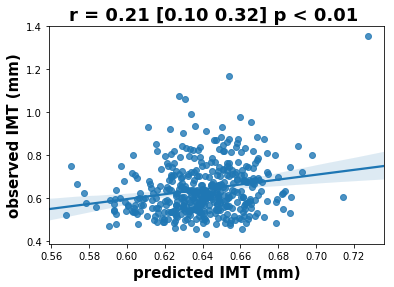

In [117]:
sns.regplot(y_pred, y_old_faces)
plt.xlabel("predicted IMT (mm)", fontsize=15, fontweight = "bold")
plt.ylabel("observed IMT (mm)", fontsize=15, fontweight = "bold")
if p < 0.01:
    plt.title("r = %.2f [%.2f %.2f] p < 0.01 " % (r, l_ci, h_ci), fontsize=18, fontweight = "bold")
else:
    plt.title("r = %.2f [%.2f %.2f] p = %.2f " % (r, l_ci, h_ci, p),fontsize=18, fontweight = "bold")

In [127]:
clf.fit(X, y_old_faces)
weight_map = np.matmul(clf.named_steps['pca'].components_.T, clf.named_steps['lassocv'].coef_)

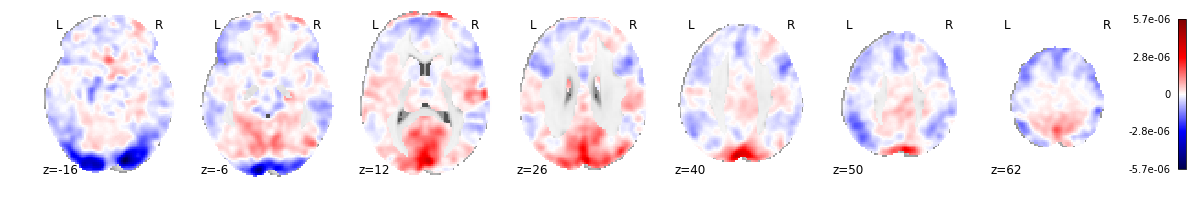

In [156]:
from scipy.stats import zscore
plotting.plot_stat_map(masking.unmask(weight_map, mask_img=mask_img), 
                       threshold=0., display_mode='z', cmap=plt.cm.seismic)

In [175]:
def calc_boots_weights(estimator, X, y, stratify, i_boot):
    from sklearn.utils import resample
    X_boot, y_boot = resample(X, y, stratify = stratify, random_state = i_boot)
    estimator.fit(X,y)
    
    weights = np.matmul(estimator.named_steps['pca'].components_.T, 
                        estimator.named_steps['lassocv'].coef_)
    return weights

In [178]:
from joblib import Parallel, delayed

t_0 = time.time()
weight_map_boots = Parallel(n_jobs=5)(delayed(calc_boots_weights)(estimator = clf, 
                                                                   X = X, 
                                                                   y = y_old_faces, 
                                                                   stratify = discrete_old_faces, 
                                                                   i_boot = ii) for ii in range(n_boot))

t_f = time.time()

In [183]:
np.save("old_faces_omnibus_boot.npy", np.array(weight_map_boots))

In [322]:
weight_map_boots = np.array(weight_map_boots)

In [323]:
alpha = 0.05
low_ci_boot = np.quantile(weight_map_boots, q=[alpha/2], axis=0)
high_ci_boot = np.quantile(weight_map_boots, q=[1-alpha/2], axis=0)

In [324]:
mask_sig = (low_ci_boot*high_ci_boot)>0

In [326]:
sum(mask_sig)

199001

In [204]:
n_boot = 1000

t_0 = time.time()

np.random.seed(RANDOM_STATE)

weight_map_boots_2 = []
for ii in range(n_boot):
    
    X_boot, y_boot = resample(X, y_old_faces)
    
    
    clf.fit(X_boot, y_boot)
    weight_map_boots_2.append(np.matmul(clf.named_steps['pca'].components_.T, 
                                        clf.named_steps['lassocv'].coef_))
    
    if ii % 100 == 0:
        print("bootstrap iteration %d finished " % ii)
        
t_f = time.time()

bootstrap iteration 0 finished 
bootstrap iteration 100 finished 
bootstrap iteration 200 finished 
bootstrap iteration 300 finished 
bootstrap iteration 400 finished 
bootstrap iteration 500 finished 
bootstrap iteration 600 finished 
bootstrap iteration 700 finished 
bootstrap iteration 800 finished 
bootstrap iteration 900 finished 


In [209]:
weight_map_boots_2 = np.array(weight_map_boots_2)

In [211]:
alpha = 0.05

low_ci = np.array([np.quantile(weight_map_boots_2[:,ii], q=[alpha/(2)]) \
                   for ii in range(weight_map_boots_2.shape[1])])

high_ci = np.array([np.quantile(weight_map_boots_2[:,ii], q=[1-alpha/(2)]) \
                    for ii in range(weight_map_boots_2.shape[1])])

In [229]:
mask_sig = (low_ci.flatten()*high_ci.flatten())>0

In [327]:
weight_map_thr = masking.unmask(mask_sig*weight_map, mask_img=mask_img)

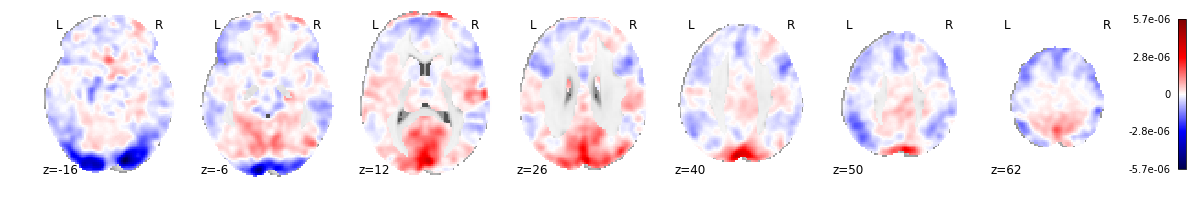

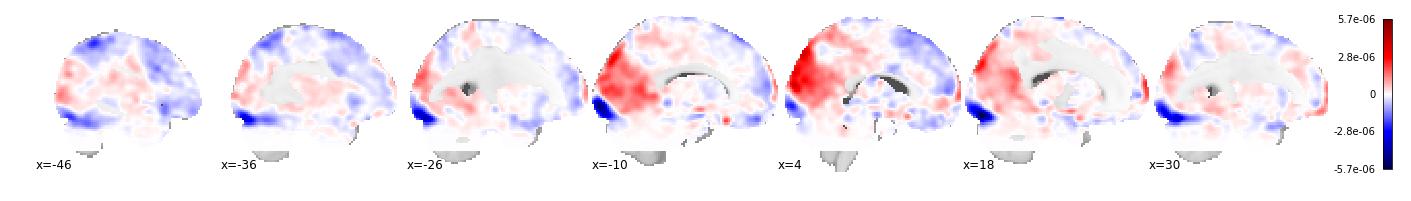

In [328]:
from scipy.stats import zscore
plotting.plot_stat_map(weight_map_thr, 
                       threshold=0., display_mode='z', cmap=plt.cm.seismic)

plotting.plot_stat_map(weight_map_thr, 
                       threshold=0., display_mode='x', cmap=plt.cm.seismic)

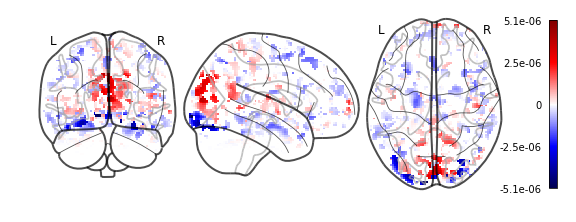

In [256]:
plotting.plot_glass_brain(weight_map_thr, 
                          threshold=0., 
                          cmap=plt.cm.seismic, colorbar = True, 
                          plot_abs=False)

In [293]:
from nilearn.regions import connected_regions
voxel_size = 2 
k_voxels = 50

regions_extracted_img_pos, _ = connected_regions(masking.unmask(mask_sig*weight_map, mask_img = mask_img), 
                                             min_region_size=k_voxels*voxel_size**3)

regions_extracted_img_neg, _ = connected_regions(masking.unmask(-1*mask_sig*weight_map, mask_img = mask_img), 
                                             min_region_size=k_voxels*voxel_size**3)

In [294]:
new_data = np.zeros(mask_img.shape)

for img in image.iter_img(regions_extracted_img_pos):
    new_data += img.get_data().copy()

for img in image.iter_img(regions_extracted_img_neg):
    new_data -= img.get_data().copy()
    
img_vox_thr = image.new_img_like(mask_img, new_data)

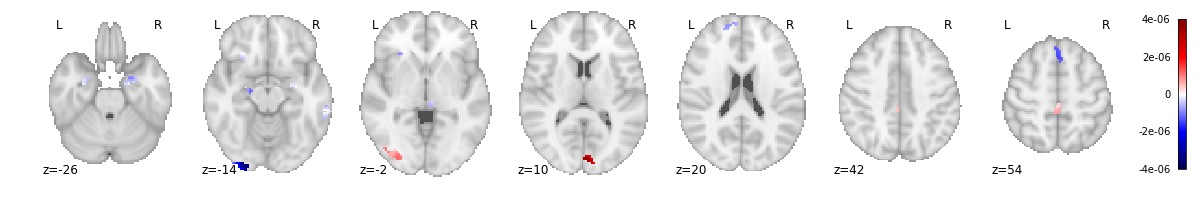

In [299]:
plotting.plot_stat_map(img_vox_thr, 
                       threshold=0., display_mode='z', cmap=plt.cm.seismic)

In [355]:
cv_outer = StratifiedKFold(n_splits=5,  shuffle = True, random_state=RANDOM_STATE).split(np.zeros(len(discrete_old_faces)), 
                                                                                   discrete_old_faces)
y_pred_list = []
y_true_list = []

for train_index, test_index in cv_outer:
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y_old_faces[train_index], y_old_faces[test_index]
    
    y_train_binned = discrete_old_faces[train_index]
    
    cv_inner = StratifiedKFold(n_splits=5,  random_state=RANDOM_STATE).split(np.zeros(len(y_train_binned)), 
                                                                                   y_train_binned)
    clf = make_pipeline(StandardScaler(with_std=False),
                        PCA(n_components = 0.95), 
                        LassoCV(max_iter=1e5,random_state=RANDOM_STATE, cv=cv_inner))
    
    clf.fit(X_train, y_train)
    y_pred_list.append(clf.predict(X_test))
    y_true_list.append(y_test)

In [356]:
y_pred = np.concatenate(y_pred_list)
y_true = np.concatenate(y_true_list)

r, p = pearsonr(y_pred, y_true)

In [357]:
n_boot = 10000

corr_boot = []
np.random.seed(RANDOM_STATE)
for ii in range(n_boot):
    boot_idxs = np.random.choice(a = len(y_pred), size=len(y_pred))
    
    corr_boot.append(np.corrcoef(y_pred[boot_idxs],
                                 y_true[boot_idxs])[0,1])

corr_boot = np.array(corr_boot)

alpha = 0.05
l_ci = np.quantile(corr_boot, alpha/2.)
h_ci = np.quantile(corr_boot, 1 - alpha/2.)

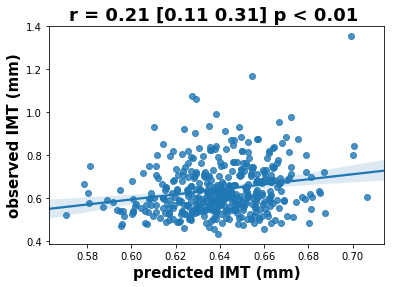

In [358]:
sns.regplot(y_pred, y_true)
plt.xlabel("predicted IMT (mm)", fontsize=15, fontweight = "bold")
plt.ylabel("observed IMT (mm)", fontsize=15, fontweight = "bold")
if p < 0.01:
    plt.title("r = %.2f [%.2f %.2f] p < 0.01 " % (r, l_ci, h_ci), fontsize=18, fontweight = "bold")
else:
    plt.title("r = %.2f [%.2f %.2f] p = %.2f " % (r, l_ci, h_ci, p),fontsize=18, fontweight = "bold")